In [1]:
import pandas as pd
import numpy as np
#import sklearn.neighbors
from sklearn.metrics import DistanceMetric
from datetime import datetime, timezone

#### Data locations

In [2]:
gis_path = "./../data/input-data/dish/gis/"

#### Load GIS data

In [3]:
gis_df = pd.read_csv("{}gis.csv".format(gis_path), names = ['Name','CILAC', 'SectorID', 'RNC_BSC', 'LAC', 'SectorType', 'Scr_Freq', \
                                                            'UARFCN', 'BSIC', 'Tech', 'Latitude', 'Longitude','Bearing','AvgNeighborDist', \
                                                            'MaxNeighborDist', 'NeighborsCount', 'Eng', 'TiltE','TiltM', 'SiteID', \
                                                            'AdminCellState', 'Asset', 'Asset_Configuration', 'Cell_Type', 'Cell_Name', \
                                                            'City', 'Height', 'RF_Team', 'Asset_Calc', 'Sector_uniq', 'FreqType', 'TAC', \
                                                            'RAC', 'Band', 'Vendor', 'CPICHPwr', 'MaxTransPwr', 'FreqMHz', 'HBW', \
                                                            'VBW', 'Antenna'])
gis_df.head(1)

,Name,CILAC,SectorID,RNC_BSC,LAC,SectorType,Scr_Freq,UARFCN,BSIC,Tech,...,TAC,RAC,Band,Vendor,CPICHPwr,MaxTransPwr,FreqMHz,HBW,VBW,Antenna
0,KNTYS00368A_n70_AWS-4_UL5_1,41036398814,1036398814,-1,-1,401500,405,401500,NaN,NR_Dish,...,25498.0,NaN,n70_AWS-4_UL5,NaN,NaN,45.07,2007.5,61.5,4.935897,KNTYS00368A


In [4]:
gis_df.shape

(341746, 41)

In [ ]:
def getContributers(source_df, dest_df):
    source_df.rename(columns = {'Name' : 'source_name'}, inplace = True)
    dest_df.rename(columns = {'Name' : 'dest_name'}, inplace = True)
    source_df[['lat_radians','long_radians']] = (np.radians(source_df.loc[:,['Latitude','Longitude']]))

    dest_df[['lat_radians','long_radians']] = (np.radians(dest_df.loc[:,['Latitude','Longitude']]))
    
    #dist = sklearn.neighbors.DistanceMetric.get_metric
    dist = DistanceMetric.get_metric('haversine')
    dist_matrix = (dist.pairwise(source_df[['lat_radians','long_radians']],
                                 dest_df[['lat_radians','long_radians']]) * 6371.1)

    df_dist_matrix = (pd.DataFrame(dist_matrix,index=source_df['source_name'], columns=dest_df['dest_name']))

    df_dist = (pd.melt(df_dist_matrix.reset_index(),id_vars='source_name'))
    df_dist = df_dist.rename(columns={'value':'Distance'})
    df_dist = df_dist[df_dist['Distance'] >= 15.0].copy()
    return df_dist

i = 0
for rf_team in set(gis_df['RF_Team'].to_list()):
    print("Working on market: {}, time = {}".format(rf_team, datetime.now()))
    if i == 0:
        compare_df = getContributers(gis_df[gis_df['RF_Team'] == rf_team][['Name', 'Latitude', 'Longitude']], gis_df[gis_df['RF_Team'] != rf_team][['Name', 'RF_Team', 'Latitude', 'Longitude']])
    else:
        temp_compare_df = getContributers(gis_df[gis_df['RF_Team'] == rf_team][['Name', 'Latitude', 'Longitude']], gis_df[gis_df['RF_Team'] != rf_team][['Name', 'RF_Team', 'Latitude', 'Longitude']])
        compare_df = pd.concat(compare_df, temp_compare_df)
    i += 1
    if i == 2:
        break

Working on market: SD, time = 2025-02-28 14:01:48.283925


In [10]:
def getContributers(name, lat, lon, df):
    R = 6373.0 * 1000
    return_name = []
    return_rf_team = []
    
    for index, row in df.iterrows():
        lat1 = math.radians(lat)
        lon1 = math.radians(lon)
        lat2 = math.radians(row['Latitude'])
        lon2 = math.radians(row['Longitude'])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = (math.sin(dlat/2))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(dlon/2))**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = R * c
        if distance < 15000:
            return_name.append(row['Name'])
            return_rf_team.append(row['RF_Team'])
    print(return_name, return_rf_team)
    return return_name, return_rf_team

gis_df['contibuter_Name'], gis_df['contibuter_RF_Team'] = zip(*gis_df.apply(lambda x: getContributers(x.Name, x.Latitude, x.Longitude, gis_df[gis_df['RF_Team'] != x.RF_Team][['Name', 'RF_Team', 'Latitude', 'Longitude']]), axis = 1))

[] []
[] []
[] []
[] []
[] []
[] []


KeyboardInterrupt: 

In [24]:
gis_df = gis_df[['Name', 'CILAC', 'Scr_Freq', 'UARFCN', 'Latitude', 'Longitude', 'Bearing', 'TiltE', 'TiltM', \
                 'SiteID', 'City', 'Height', 'TAC', 'Band', 'Vendor', 'MaxTransPwr', 'FreqMHz', 'HBW']]

print("Rows pre merge = {}".format(grid_transpose.shape[0]))
grid_transpose = pd.merge(grid_transpose,gis_df,how='inner',left_on='cell', right_on = 'CILAC')
print("Rows post merge = {}".format(grid_transpose.shape[0]))


Rows pre merge = 1108808
Rows post merge = 1108808


In [25]:
grid_transpose.head()

,cell,geohash,grid_cell,avg_rsrp,avg_rsrq,avg_sinr,event_count,grid_event_count,avg_rsrp_geohash,avg_rsrq_geo_hash,avg_sinr_geohash,cell_event_count,avg_rsrp_cell,avg_rsrq_cell,avg_sinr_cell,perc_cell_events,perc_grid_events,Name,CILAC,Scr_Freq,UARFCN,Latitude,Longitude,Bearing,TiltE,TiltM,SiteID,City,Height,TAC,Band,Vendor,MaxTransPwr,FreqMHz,HBW
0,4577540102,9xs7d,9xs7d_4577540102,-107.3,-12.3,4.1,45.0,258.0,-104.492788,-11.332692,7.669391,2115.0,-103.986958,-12.009351,6.036175,0.021277,0.174419,DNCPR00001B_n71_A_1,4577540102,357,123900,42.810547,-106.296597,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504
1,4577540102,9xs7dx,9xs7dx_4577540102,-107.3,-12.3,4.1,45.0,183.0,-104.637500,-11.493750,7.050000,2115.0,-103.986958,-12.009351,6.036175,0.021277,0.245902,DNCPR00001B_n71_A_1,4577540102,357,123900,42.810547,-106.296597,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504
2,4577540102,9xs7dx3,9xs7dx3_4577540102,-105.0,-16.0,-3.0,9.0,24.0,-105.166667,-13.833333,0.333333,2115.0,-103.986958,-12.009351,6.036175,0.004255,0.375000,DNCPR00001B_n71_A_1,4577540102,357,123900,42.810547,-106.296597,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504
3,4577540102,9xs7dx4,9xs7dx4_4577540102,-109.0,-12.0,4.0,3.0,12.0,-110.250000,-12.000000,3.250000,2115.0,-103.986958,-12.009351,6.036175,0.001418,0.250000,DNCPR00001B_n71_A_1,4577540102,357,123900,42.810547,-106.296597,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504
4,4577540102,9xs7dx7,9xs7dx7_4577540102,-102.0,-11.0,9.0,3.0,6.0,-98.000000,-12.000000,5.000000,2115.0,-103.986958,-12.009351,6.036175,0.001418,0.500000,DNCPR00001B_n71_A_1,4577540102,357,123900,42.810547,-106.296597,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504


In [26]:
grid_transpose["geometry"] = grid_transpose.apply(lambda x: "POINT (" + str(geohash.decode(x.geohash)).split(", ")[1].replace(")", "") + " " + str(geohash.decode(x.geohash)).split(", ")[0].replace("(", "") + ")", axis = 1)

In [27]:
grid_transpose['geometry'] = grid_transpose['geometry'].apply(lambda x: shapely.wkt.loads(x))
grid_transpose_gdf = gpd.GeoDataFrame(grid_transpose, geometry='geometry', crs='EPSG:4326')

In [28]:
grid_transpose_gdf.head(2)

,cell,geohash,grid_cell,avg_rsrp,avg_rsrq,avg_sinr,event_count,grid_event_count,avg_rsrp_geohash,avg_rsrq_geo_hash,avg_sinr_geohash,cell_event_count,avg_rsrp_cell,avg_rsrq_cell,avg_sinr_cell,perc_cell_events,perc_grid_events,Name,CILAC,Scr_Freq,UARFCN,Latitude,Longitude,Bearing,TiltE,TiltM,SiteID,City,Height,TAC,Band,Vendor,MaxTransPwr,FreqMHz,HBW,geometry
0,4577540102,9xs7d,9xs7d_4577540102,-107.3,-12.3,4.1,45.0,258.0,-104.492788,-11.332692,7.669391,2115.0,-103.986958,-12.009351,6.036175,0.021277,0.174419,DNCPR00001B_n71_A_1,4577540102,357,123900,42.810547,-106.296597,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504,POINT (-106.41357 42.82471)
1,4577540102,9xs7dx,9xs7dx_4577540102,-107.3,-12.3,4.1,45.0,183.0,-104.637500,-11.493750,7.050000,2115.0,-103.986958,-12.009351,6.036175,0.021277,0.245902,DNCPR00001B_n71_A_1,4577540102,357,123900,42.810547,-106.296597,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504,POINT (-106.40808 42.84393)


In [29]:
grid_transpose_gdf.head(100).explore()

#### Find distance from Grid to cell and Angle from cell to Grid

In [30]:
def findDistance(geom, lat_cell, lon_cell):
    '''
    This function returns;
        - Distance from cell to centroid of the bin
        - Percentage of max propagation
        - Weighted distance
        - Angle from cell to centroid of the bin
    '''
    grid_lon = float(str(geom).split(" ")[1].replace("(", ""))
    grid_lat = float(str(geom).split(" ")[2].replace(")", ""))
    R = 6373.0 * 1000

    lat1 = math.radians(lat_cell)
    lon1 = math.radians(lon_cell)
    lat2 = math.radians(grid_lat)
    lon2 = math.radians(grid_lon)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (math.sin(dlat/2))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(dlon/2))**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c

    angle = math.degrees(math.atan2(grid_lat - lat_cell, (grid_lon) - (lon_cell)))
    if angle <= 0:
        angle = angle + 360

    angle = math.fabs(angle - 450) % 360
    
    return distance, angle

grid_transpose_gdf['distance_to_cell'], grid_transpose_gdf['cell_angle_to_grid'] = zip(*grid_transpose_gdf.apply(lambda x: findDistance(x.geometry, x.Latitude, x.Longitude), axis = 1))


#### Find max distance to any cell from the grid
#### Find min distance to any cell from the grid
#### Find max distance that the cell serves

In [31]:
grid_max_dist = grid_transpose_gdf[['geohash', 'distance_to_cell']].groupby(['geohash']).max().reset_index()
grid_max_dist.rename(columns={'distance_to_cell': 'grid_max_distance_to_cell'}, inplace=True)

grid_min_dist = grid_transpose_gdf[['geohash', 'distance_to_cell']].groupby(['geohash']).min().reset_index()
grid_min_dist.rename(columns={'distance_to_cell': 'grid_min_distance_to_cell'}, inplace=True)

cell_max_dist = grid_transpose_gdf[['cell', 'distance_to_cell']].groupby(['cell']).max().reset_index()
cell_max_dist.rename(columns={'distance_to_cell': 'cell_max_distance_to_cell'}, inplace=True)

In [32]:
data_frames_1 = [grid_transpose_gdf, grid_max_dist, grid_min_dist]
grid_transpose_gdf = reduce(lambda  left,right: pd.merge(left,right,on=['geohash'], how='outer'), data_frames_1)

data_frames_2 = [grid_transpose_gdf, cell_max_dist]
grid_transpose_gdf = reduce(lambda  left,right: pd.merge(left,right,on=['cell'], how='outer'), data_frames_2)


#### Calculate the % of the max distance from cell the current cells is

In [33]:
grid_transpose_gdf['perc_cell_max_dist'] = grid_transpose_gdf.apply(lambda x: calcPercentage(x.distance_to_cell, x.cell_max_distance_to_cell), axis = 1)


#### Calcuate bearing to grid centroid difference

In [34]:
def getBearingDiff(cell_angle_to_grid, bearing):
    grid_bearing_diff = math.fabs(cell_angle_to_grid - bearing)
    if grid_bearing_diff > 180:
        grid_bearing_diff = 360 - grid_bearing_diff
    return grid_bearing_diff
        



grid_transpose_gdf['grid_bearing_diff'] = grid_transpose_gdf.apply(lambda x: getBearingDiff(x['cell_angle_to_grid'], x['Bearing']), axis = 1)


In [36]:
grid_transpose_gdf.columns

Index(['cell', 'geohash', 'grid_cell', 'avg_rsrp', 'avg_rsrq', 'avg_sinr',
       'event_count', 'grid_event_count', 'avg_rsrp_geohash',
       'avg_rsrq_geo_hash', 'avg_sinr_geohash', 'cell_event_count',
       'avg_rsrp_cell', 'avg_rsrq_cell', 'avg_sinr_cell', 'perc_cell_events',
       'perc_grid_events', 'Name', 'CILAC', 'Scr_Freq', 'UARFCN', 'Latitude',
       'Longitude', 'Bearing', 'TiltE', 'TiltM', 'SiteID', 'City', 'Height',
       'TAC', 'Band', 'Vendor', 'MaxTransPwr', 'FreqMHz', 'HBW', 'geometry',
       'distance_to_cell', 'cell_angle_to_grid', 'grid_max_distance_to_cell',
       'grid_min_distance_to_cell', 'cell_max_distance_to_cell',
       'perc_cell_max_dist', 'grid_bearing_diff'],
      dtype='object')

In [37]:
grid_transpose_gdf = grid_transpose_gdf[['grid_cell', 'geohash', 'Name', 'CILAC', 'avg_rsrp', 'avg_rsrq', 'avg_sinr', 'event_count', \
                    'grid_event_count', 'cell_event_count', 'avg_rsrp_geohash', 'avg_rsrq_geo_hash', 'avg_sinr_geohash', \
                    'avg_rsrp_cell', 'avg_rsrq_cell', 'avg_sinr_cell', 'perc_cell_events', 'perc_grid_events',  'distance_to_cell', \
                    'grid_max_distance_to_cell', 'grid_min_distance_to_cell', 'cell_max_distance_to_cell', 'perc_cell_max_dist', \
                    'cell_angle_to_grid', 'grid_bearing_diff', 'Scr_Freq', 'UARFCN', 'Bearing', 'TiltE', 'TiltM', 'SiteID', 'City', \
                    'Height', 'TAC', 'Band', 'Vendor', 'MaxTransPwr', 'FreqMHz', 'HBW', 'geometry']]

In [38]:
grid_transpose_gdf.head(2)

,grid_cell,geohash,Name,CILAC,avg_rsrp,avg_rsrq,avg_sinr,event_count,grid_event_count,cell_event_count,avg_rsrp_geohash,avg_rsrq_geo_hash,avg_sinr_geohash,avg_rsrp_cell,avg_rsrq_cell,avg_sinr_cell,perc_cell_events,perc_grid_events,distance_to_cell,grid_max_distance_to_cell,grid_min_distance_to_cell,cell_max_distance_to_cell,perc_cell_max_dist,cell_angle_to_grid,grid_bearing_diff,Scr_Freq,UARFCN,Bearing,TiltE,TiltM,SiteID,City,Height,TAC,Band,Vendor,MaxTransPwr,FreqMHz,HBW,geometry
0,9xs7d_4577540102,9xs7d,DNCPR00001B_n71_A_1,4577540102,-107.3,-12.3,4.1,45.0,258.0,2115.0,-104.492788,-11.332692,7.669391,-103.986958,-12.009351,6.036175,0.021277,0.174419,9673.185744,9673.185744,2653.770391,11523.717399,0.839415,276.902043,53.097957,357,123900,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504,POINT (-106.41357 42.82471)
1,9xs7dx_4577540102,9xs7dx,DNCPR00001B_n71_A_1,4577540102,-107.3,-12.3,4.1,45.0,183.0,2115.0,-104.637500,-11.493750,7.050000,-103.986958,-12.009351,6.036175,0.021277,0.245902,9823.454984,9823.454984,539.222281,11523.717399,0.852455,286.671369,43.328631,357,123900,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504,POINT (-106.40808 42.84393)


## Data checks

#### Histograms

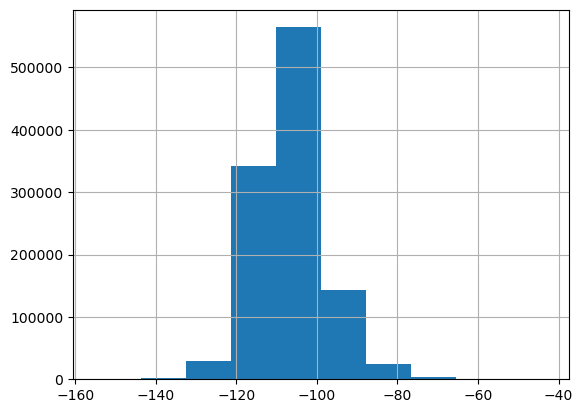

In [37]:
grid_transpose_gdf.avg_rsrp.hist();

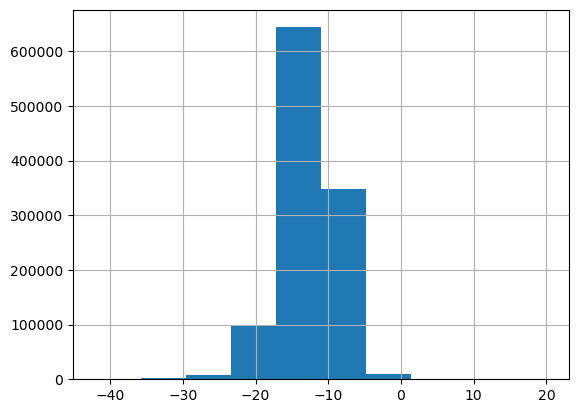

In [38]:
grid_transpose_gdf.avg_rsrq.hist();

<Axes: >

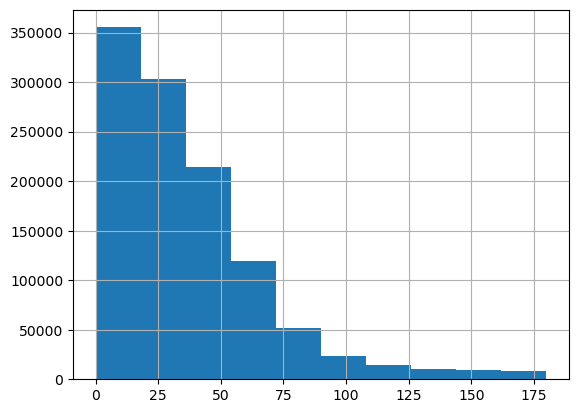

In [39]:
grid_transpose_gdf['grid_bearing_diff'].hist()

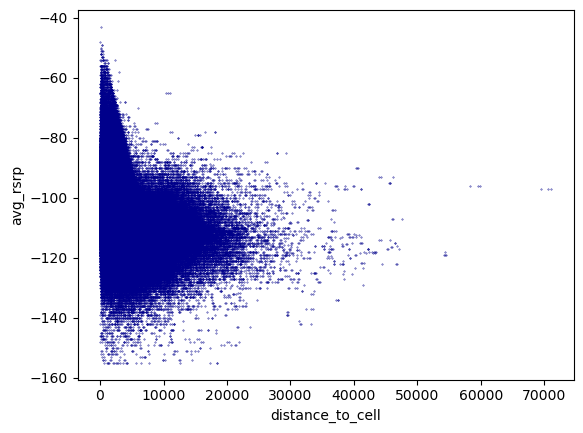

In [40]:
ax1 = grid_transpose_gdf.plot.scatter(x='distance_to_cell', y='avg_rsrp', c='DarkBlue', s = 0.1)

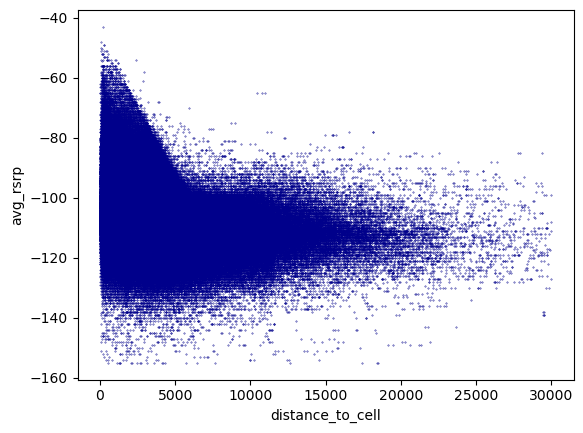

In [41]:
ax1 = grid_transpose_gdf[grid_transpose_gdf.distance_to_cell <= 30000].plot.scatter(x='distance_to_cell', y='avg_rsrp', \
                                                                                    c='DarkBlue', s = 0.1)

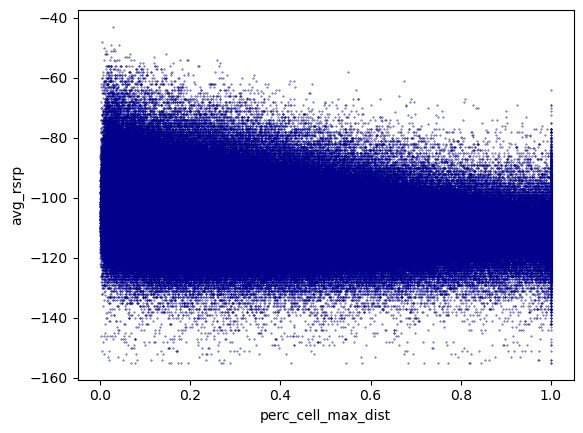

In [42]:
ax1 = grid_transpose_gdf.plot.scatter(x='perc_cell_max_dist', y='avg_rsrp', c='DarkBlue', s = 0.1)

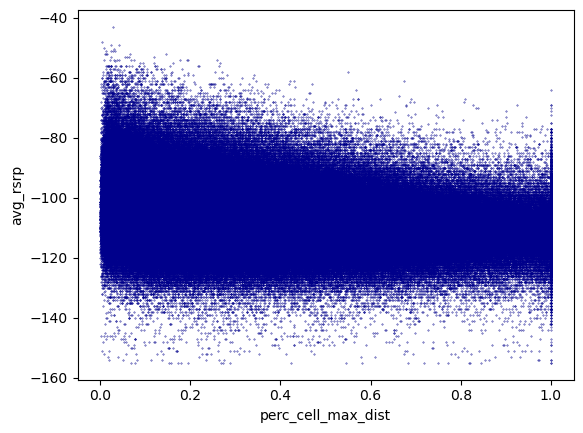

In [43]:
ax1 = grid_transpose_gdf[grid_transpose_gdf.distance_to_cell <= 30000].plot.scatter(x='perc_cell_max_dist', y='avg_rsrp', \
                                                                                    c='DarkBlue', s = 0.1)

#### Filter data by distance

In [44]:
max_dist = 32000
print("Pre distance filtering rows = {}".format(grid_transpose_gdf.shape[0]))
grid_transpose_gdf = grid_transpose_gdf[grid_transpose_gdf.distance_to_cell <= max_dist]
print("Post distance filtering rows = {}".format(grid_transpose_gdf.shape[0]))

Pre distance filtering rows = 1108808
Post distance filtering rows = 1108581


In [1]:
grid_transpose_gdf.head()

NameError: name 'grid_transpose_gdf' is not defined

In [46]:
grid_transpose_gdf.rename(columns={'geohash': 'grid', 'Name' : 'cell_name', 'CILAC' : 'cilac', \
                                  'avg_rsrp_geohash' : 'avg_rsrp_grid',	'avg_rsrq_geo_hash' : 'avg_rsrq_grid', \
                                   'avg_sinr_geohash' : 'avg_sinr_grid', }, inplace=True)

/var/folders/vx/v2s2cp2d233bk24wrz0wfw8h0000gn/T/ipykernel_68182/2393861296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_transpose_gdf.rename(columns={'geohash': 'grid', 'Name' : 'cell_name', 'CILAC' : 'cilac', \


In [2]:
data_path = "./../data/output-data/dish/grid/"

In [6]:
grid_df = pd.read_csv("{}grid-cell-data.csv".format(data_path))#, nrows = 10000)
grid_df['geometry'] = grid_df['geometry'].apply(lambda x: shapely.wkt.loads(x))
grid_gdf = gpd.GeoDataFrame(grid_df, geometry='geometry', crs='EPSG:4326')

In [7]:
grid_gdf.head()

,grid_cell,grid,cell_name,cilac,avg_rsrp,avg_rsrq,avg_sinr,event_count,grid_event_count,cell_event_count,avg_rsrp_grid,avg_rsrq_grid,avg_sinr_grid,avg_rsrp_cell,avg_rsrq_cell,avg_sinr_cell,perc_cell_events,perc_grid_events,distance_to_cell,grid_max_distance_to_cell,grid_min_distance_to_cell,cell_max_distance_to_cell,perc_cell_max_dist,cell_angle_to_grid,grid_bearing_diff,Scr_Freq,UARFCN,Bearing,TiltE,TiltM,SiteID,City,Height,TAC,Band,Vendor,MaxTransPwr,FreqMHz,HBW,geometry
0,9xs7d_4577540102,9xs7d,DNCPR00001B_n71_A_1,4577540102,-107.3,-12.3,4.1,45.0,258.0,2115.0,-104.492788,-11.332692,7.669391,-103.986958,-12.009351,6.036175,0.021277,0.174419,9673.185744,9673.185744,2653.770391,11523.717399,0.839415,276.902043,53.097957,357,123900,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504,POINT (-106.41357 42.82471)
1,9xs7dx_4577540102,9xs7dx,DNCPR00001B_n71_A_1,4577540102,-107.3,-12.3,4.1,45.0,183.0,2115.0,-104.637500,-11.493750,7.050000,-103.986958,-12.009351,6.036175,0.021277,0.245902,9823.454984,9823.454984,539.222281,11523.717399,0.852455,286.671369,43.328631,357,123900,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504,POINT (-106.40808 42.84393)
2,9xs7dx3_4577540102,9xs7dx3,DNCPR00001B_n71_A_1,4577540102,-105.0,-16.0,-3.0,9.0,24.0,2115.0,-105.166667,-13.833333,0.333333,-103.986958,-12.009351,6.036175,0.004255,0.375000,10055.470676,10055.470676,585.788303,11523.717399,0.872589,285.883586,44.116414,357,123900,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504,POINT (-106.41151 42.84325)
3,9xs7dx4_4577540102,9xs7dx4,DNCPR00001B_n71_A_1,4577540102,-109.0,-12.0,4.0,3.0,12.0,2115.0,-110.250000,-12.000000,3.250000,-103.986958,-12.009351,6.036175,0.001418,0.250000,9896.396326,9896.396326,732.672146,11523.717399,0.858785,285.423891,44.576109,357,123900,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504,POINT (-106.41014 42.84187)
4,9xs7dx7_4577540102,9xs7dx7,DNCPR00001B_n71_A_1,4577540102,-102.0,-11.0,9.0,3.0,6.0,2115.0,-98.000000,-12.000000,5.000000,-103.986958,-12.009351,6.036175,0.001418,0.500000,9846.916646,9846.916646,595.683669,11523.717399,0.854491,286.252204,43.747796,357,123900,330,8.0,0,42.8105_-106.297,Casper,39.624,14299.0,n71_A,NaN,44.77,619.5,70.290504,POINT (-106.40877 42.84325)


In [8]:
grid_gdf.shape

(1108581, 40)

#### Classifications

In [19]:
def dominanceClassify(perc_grid_events, perc_cell_max_dist):
    if perc_grid_events >= 0.3:
        dominance = 'dominant'
    elif perc_grid_events <= 0.02:
        dominance = "interferer"
    else:
        dominance = "contibutor"

    if perc_cell_max_dist >= 0.95:
        tier = 'tier_4'
    elif perc_grid_events >= 0.7:
        tier = "tier_3"
    elif perc_grid_events >= 0.35:
        tier = "tier_2"
    else:
        tier = "tier_1"
    return dominance, tier

grid_gdf['dominance'], grid_gdf['dist_band'] = zip(*grid_gdf.apply(lambda x: dominanceClassify(x.perc_grid_events, x.perc_cell_max_dist), axis = 1))

<Axes: >

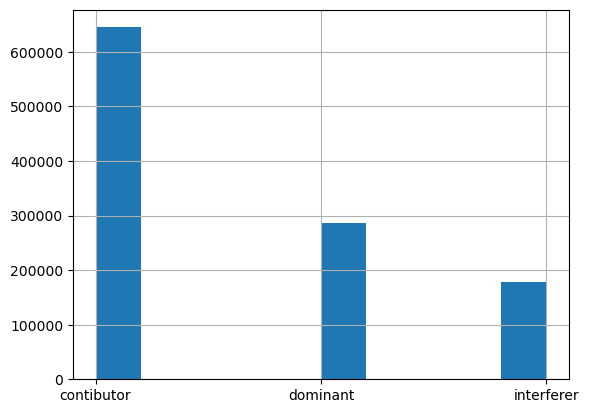

In [20]:
grid_gdf['dominance'].hist()

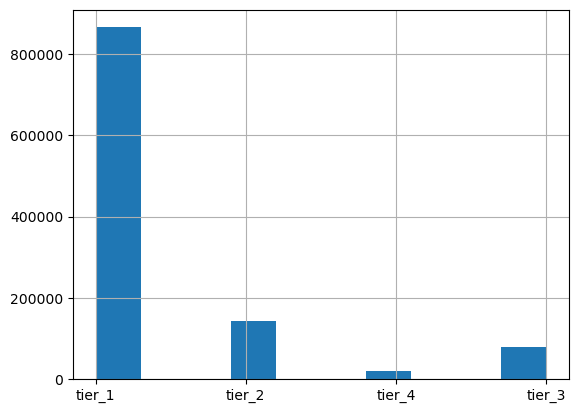

In [21]:
grid_gdf['dist_band'].hist();

In [22]:
grid_gdf['dominance-dist_band'] = grid_gdf['dominance'] + "_" + grid_gdf['dist_band']

In [23]:
grid_gdf['dominance-dist_band'].value_counts()

dominance-dist_band
contibutor_tier_1    638956
interferer_tier_1    165967
dominant_tier_2      142957
dominant_tier_3       80174
dominant_tier_1       60830
interferer_tier_4     12020
contibutor_tier_4      6016
dominant_tier_4        1661
Name: count, dtype: int64

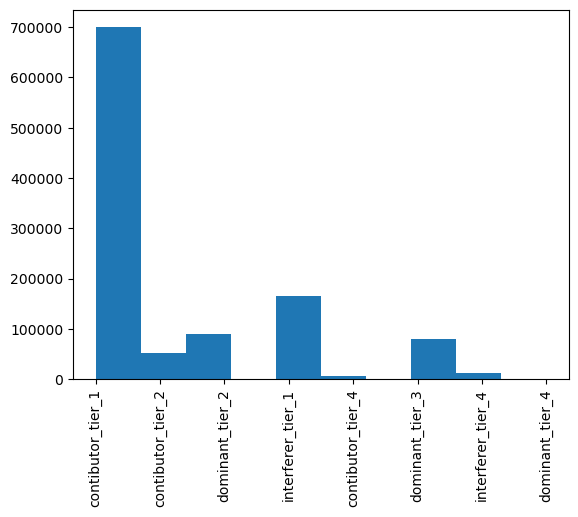

In [17]:
p = plt.hist(grid_gdf['dominance-dist_band'])
plt.xticks(rotation='vertical')

plt.show()

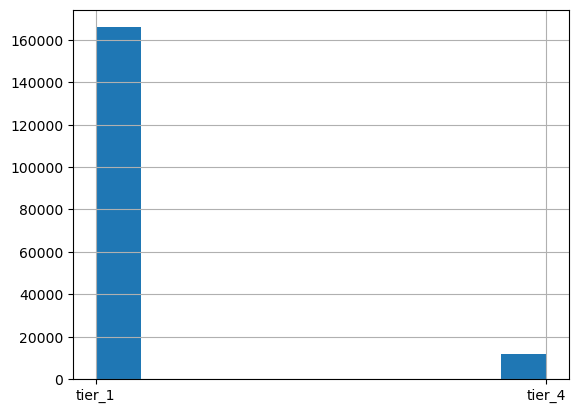

In [66]:
grid_transpose_gdf[grid_transpose_gdf['dominance'] == "interferer"]['dist_band'].hist();
#grid_transpose_gdf[grid_transpose_gdf['dominance'] == "contibutor"]['dist_band'].hist();
#grid_transpose_gdf[grid_transpose_gdf['dominance'] == "dominant"]['dist_band'].hist();


In [77]:
#grid_transpose_gdf.to_file("{}initial_grid.json".format(intermediate_path))

## Recommendations

In [78]:
grid_transpose_gdf.shape

(1108581, 40)

In [111]:
gis_df["geometry"] = gis_df.apply(lambda x: "POINT (" + str(x.Longitude) + " " + str(x.Latitude) + ")", axis = 1)
gis_df['geometry'] = gis_df['geometry'].apply(lambda x: shapely.wkt.loads(x))
gis_df = gpd.GeoDataFrame(gis_df, geometry='geometry', crs='EPSG:4326')


/var/folders/vx/v2s2cp2d233bk24wrz0wfw8h0000gn/T/ipykernel_65059/2101211081.py:1: UserWarning: Geometry column does not contain geometry.
  gis_df["geometry"] = gis_df.apply(lambda x: "POINT (" + str(x.Longitude) + " " + str(x.Latitude) + ")", axis = 1)


## Import final dataset from output folder for classification / recommendation insights

## Crossed Feeders

In [131]:
potential_crossed_feeders = grid_transpose_gdf[grid_transpose_gdf['grid_bearing_diff'] >= 90]

In [132]:
potential_crossed_feeders = potential_crossed_feeders[['Name', 'perc_cell_events', 'event_count']].groupby(['Name']).sum().reset_index()
potential_crossed_feeders.rename(columns={'perc_cell_events': 'perc_traffic_outside_beam'}, inplace=True)
potential_crossed_feeders = potential_crossed_feeders.sort_values(["perc_traffic_outside_beam", "event_count"], ascending = [False, False]).reset_index()
potential_crossed_feeders.head(20)

,index,Name,perc_traffic_outside_beam,event_count
0,4891,DNDEN00158A_n66_G_3,1.0,63.0
1,1903,DADAL00290A_n66_G_3,1.0,27.0
2,3884,DATYR00031A_n71_A_2,1.0,27.0
3,5585,DNDEN00302A_n66_G_1,1.0,27.0
4,5888,DNDEN00370C_n66_G_2,1.0,27.0
5,7210,HOHOU00413A_n70_AWS-4_UL15_3,1.0,27.0
6,3908,DATYR00044A_n70_AWS-4_UL15_3,1.0,18.0
7,3993,DNCPR00009A_n71_A_2,1.0,18.0
8,4770,DNDEN00138D_n66_G_3,1.0,18.0
9,7273,HOHOU00464A_n71_A_2,1.0,18.0


In [134]:
potential_crossed_feeders[potential_crossed_feeders['Name'].str.contains("DNDEN00158A_n66")]

,index,Name,perc_traffic_outside_beam,event_count
0,4891,DNDEN00158A_n66_G_3,1.0,63.0


In [137]:
import folium
m = grid_transpose_gdf[grid_transpose_gdf['Name'] == "DNDEN00158A_n66_G_3"].explore(color = "blue", name="Grid")
m = gis_df[gis_df['Name'] == "DNDEN00158A_n66_G_3"].explore(m = m, size = '100', color="red", name="Cells")
folium.LayerControl().add_to(m)

m

In [110]:
gis_df[gis_df['Name'] == "HOHOU00268A_n71_G_2"]

,Name,CILAC,Scr_Freq,UARFCN,Latitude,Longitude,Bearing,TiltE,TiltM,SiteID,City,Height,TAC,Band,Vendor,MaxTransPwr,FreqMHz,HBW,geometry
162292,HOHOU00268A_n71_G_2,42297872433,463,129900,29.919278,-95.448861,120,6.0,0,29.9193_-95.4489,Houston,34.1376,56101.0,n71_G,NaN,39.77,649.5,64.0,POINT (-104.87054 39.56170)


#### PCI Recommendations

In [138]:
pci_grid = grid_transpose_gdf[['grid_cell', 'Scr_Freq']]

Index(['unique_id', 'geohash', 'Name', 'CILAC', 'avg_rsrp', 'avg_rsrq',
       'avg_sinr', 'event_count', 'grid_event_count', 'cell_event_count',
       'avg_rsrp_geohash', 'avg_rsrq_geo_hash', 'avg_sinr_geohash',
       'avg_rsrp_cell', 'avg_rsrq_geo_cell', 'avg_sinr_cell',
       'perc_cell_events', 'perc_grid_events', 'distance_to_cell',
       'grid_max_distance_to_cell', 'grid_min_distance_to_cell',
       'cell_max_distance_to_cell', 'perc_cell_max_dist', 'cell_angle_to_grid',
       'grid_bearing_diff', 'Scr_Freq', 'UARFCN', 'Bearing', 'TiltE', 'TiltM',
       'SiteID', 'City', 'Height', 'TAC', 'Band', 'Vendor', 'MaxTransPwr',
       'FreqMHz', 'HBW', 'geometry'],
      dtype='object')

In [153]:
pci_grid = grid_transpose_gdf[['geohash', 'Scr_Freq', 'Name']].groupby(['geohash', 'Scr_Freq']).count().reset_index()
pci_grid.rename(columns={'Name': 'same_pci_cell_count'}, inplace=True)
pci_grid = pci_grid.sort_values(["same_pci_cell_count"], ascending = False).reset_index()
pci_grid[pci_grid.Scr_Freq != 0].head()

,index,geohash,Scr_Freq,same_pci_cell_count
31,669323,9xj2g,892,5
92,679124,9xj35,892,4
109,170025,9vg13g9,510,3
110,285623,9vg5e5q,491,3
111,681132,9xj36uw,268,3


In [156]:
grid_transpose_gdf[(grid_transpose_gdf['geohash'] == "9xj2g") & (grid_transpose_gdf['Scr_Freq'] == 892)]

,unique_id,geohash,Name,CILAC,avg_rsrp,avg_rsrq,avg_sinr,event_count,grid_event_count,cell_event_count,avg_rsrp_geohash,avg_rsrq_geo_hash,avg_sinr_geohash,avg_rsrp_cell,avg_rsrq_geo_cell,avg_sinr_cell,perc_cell_events,perc_grid_events,distance_to_cell,grid_max_distance_to_cell,grid_min_distance_to_cell,cell_max_distance_to_cell,perc_cell_max_dist,cell_angle_to_grid,grid_bearing_diff,Scr_Freq,UARFCN,Bearing,TiltE,TiltM,SiteID,City,Height,TAC,Band,Vendor,MaxTransPwr,FreqMHz,HBW,geometry
226956,9xj2g_4585834923,9xj2g,DNDEN00218A_n71_F-G_2,4585834923,-120.000000,-21.0,-10.000000,6.0,1647.0,792.0,-112.88112,-16.679448,-4.000366,-114.192807,-18.425197,-6.092335,0.007576,0.003643,14558.024301,25244.753846,1784.028273,15107.601197,0.963622,114.552510,5.447490,892,129400,120,10.0,0,39.5955_-105.109,Littleton,15.5448,14498.0,n71_F-G,NaN,42.96,647.0,66.5,POINT (-104.96338 39.52881)
227062,9xj2g_4585834929,9xj2g,DNDEN00218A_n70_AWS-4_UL15_2,4585834929,-131.000000,-19.0,-8.000000,6.0,1647.0,540.0,-112.88112,-16.679448,-4.000366,-116.219812,-16.305809,-4.548998,0.011111,0.003643,14558.024301,25244.753846,1784.028273,16483.307942,0.883198,114.552510,5.447490,892,401500,120,8.0,0,39.5955_-105.109,Littleton,15.5448,14498.0,n70_AWS-4_UL5,NaN,46.04,2007.5,59.0,POINT (-104.96338 39.52881)
231355,9xj2g_4585834944,9xj2g,DNDEN00237B_n71_F-G_2,4585834944,-110.222222,-18.0,-6.111111,81.0,1647.0,2925.0,-112.88112,-16.679448,-4.000366,-110.653088,-16.728771,-3.833577,0.027692,0.049180,5519.734568,25244.753846,1784.028273,8160.454213,0.676400,183.239283,53.239283,892,129400,130,4.0,0,39.5784_-104.961,Centennial,10.6680,14498.0,n71_F-G,NaN,42.96,647.0,63.5,POINT (-104.96338 39.52881)
231905,9xj2g_4585834932,9xj2g,DNDEN00218A_n66_G_2,4585834932,-117.000000,-13.0,0.000000,6.0,1647.0,81.0,-112.88112,-16.679448,-4.000366,-119.204545,-15.045455,-2.659091,0.074074,0.003643,14558.024301,25244.753846,1784.028273,14558.024301,1.000000,114.552510,5.447490,892,431500,120,8.0,0,39.5955_-105.109,Littleton,15.5448,14498.0,n66_G,NaN,38.78,2157.5,63.0,POINT (-104.96338 39.52881)
231916,9xj2g_4585834950,9xj2g,DNDEN00237B_n70_AWS-4_UL15_2,4585834950,-83.000000,-18.0,-7.000000,3.0,1647.0,405.0,-112.88112,-16.679448,-4.000366,-108.774603,-15.578874,-1.391977,0.007407,0.001821,5519.734568,25244.753846,1784.028273,5519.734568,1.000000,183.239283,53.239283,892,401500,130,2.0,0,39.5784_-104.961,Centennial,10.6680,14498.0,n70_AWS-4_UL5,NaN,46.04,2007.5,61.5,POINT (-104.96338 39.52881)


#### Cells per Grid

In [151]:
cells_per_grid = grid_transpose_gdf[['geohash', 'Name']].groupby('geohash').count().reset_index()
cells_per_grid.rename(columns={'Name': 'cell_count'}, inplace=True)
cells_per_grid = cells_per_grid.sort_values(["cell_count"], ascending = False).reset_index()
cells_per_grid.head()

,index,geohash,cell_count
0,214778,9xj64,139
1,73502,9vg4t,133
2,204540,9xj3f,128
3,136894,9vk1m,123
4,83951,9vg5k,123
